### Grocery Sales Forecasting (Rossman)

Kaggle comp [here](https://www.kaggle.com/c/rossmann-store-sales). Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany.

Submissions are evaluated on the Root Mean Square Percentage Error (RMSPE). The submission files should be csv that maps a store ID to a sale amount in dollars:

```
Id,Sales
1,0
2,0
...
```

The files are:

- train.csv: historical data including Sales
- test.csv: historical data excluding Sales
- sample_submission.csv: a sample submission file in the correct format
- store.csv: supplemental information about the stores

This is essentially a copy of the FastAI course version of the Rossman problem. Note that in the FastAI version we also used googletrends and weather data.

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [73]:
from fastai.structured import add_datepart, apply_cats, proc_df
from fastai.dataset import get_cv_idxs
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
from isoweek import Week

PATH='/home/paperspace/fastai/courses/dl1/data/rossman/'

In [4]:
# Inspect store information
store_df = pd.read_csv(f'{PATH}store.csv', low_memory=False)
store_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
StoreType,c,a,a,c,a
Assortment,a,a,a,c,a
CompetitionDistance,1270,570,14130,620,29910
CompetitionOpenSinceMonth,9,11,12,9,4
CompetitionOpenSinceYear,2008,2007,2006,2009,2015
Promo2,0,1,1,0,0
Promo2SinceWeek,NaN,13,14,NaN,NaN
Promo2SinceYear,NaN,2010,2011,NaN,NaN
PromoInterval,NaN,"Jan,Apr,Jul,Oct","Jan,Apr,Jul,Oct",NaN,NaN


In [5]:
DataFrameSummary(store_df).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Store,1115,558,322.017,1,279.5,558,836.5,1115,1115,1115,0,0%,numeric
StoreType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1115,4,0,0%,categorical
Assortment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1115,3,0,0%,categorical
CompetitionDistance,1112,5404.9,7663.17,20,717.5,2325,6882.5,75860,1112,654,3,0.27%,numeric
CompetitionOpenSinceMonth,761,7.2247,3.21235,1,4,8,10,12,761,12,354,31.75%,numeric
CompetitionOpenSinceYear,761,2008.67,6.19598,1900,2006,2010,2013,2015,761,23,354,31.75%,numeric
Promo2,1115,0.512108,0.500078,0,0,1,1,1,1115,2,0,0%,bool
Promo2SinceWeek,571,23.5954,14.142,1,13,22,37,50,571,24,544,48.79%,numeric
Promo2SinceYear,571,2011.76,1.67494,2009,2011,2012,2013,2015,571,7,544,48.79%,numeric
PromoInterval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,571,3,544,48.79%,categorical


In [6]:
# Inspect training information
train_df = pd.read_csv(f'{PATH}train.csv', low_memory=False)
train_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1


In [7]:
DataFrameSummary(train_df).summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
Store,1.01721e+06,558.43,321.909,1,280,558,838,1115,1017209,1115,0,0%,numeric
DayOfWeek,1.01721e+06,3.99834,1.99739,1,2,4,6,7,1017209,7,0,0%,numeric
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1017209,942,0,0%,categorical
Sales,1.01721e+06,5773.82,3849.93,0,3727,5744,7856,41551,1017209,21734,0,0%,numeric
Customers,1.01721e+06,633.146,464.412,0,405,609,837,7388,1017209,4086,0,0%,numeric
Open,1.01721e+06,0.830107,0.375539,0,1,1,1,1,1017209,2,0,0%,bool
Promo,1.01721e+06,0.381515,0.485759,0,0,0,1,1,1017209,2,0,0%,bool
StateHoliday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1017209,4,0,0%,categorical
SchoolHoliday,1.01721e+06,0.178647,0.383056,0,0,0,0,1,1017209,2,0,0%,bool


In [8]:
# Inspect test information
test_df = pd.read_csv(f'{PATH}test.csv', low_memory=False)
test_df.head().T

,0,1,2,3,4
Id,1,2,3,4,5
Store,1,3,7,8,9
DayOfWeek,4,4,4,4,4
Date,2015-09-17,2015-09-17,2015-09-17,2015-09-17,2015-09-17
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,0


In [9]:
DataFrameSummary(test_df).summary()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


In [10]:
len(train_df), len(test_df)

(1017209, 41088)

In [11]:
# Extract hard-coded features from date fields
add_datepart(train_df, 'Date', drop=False)
add_datepart(test_df, 'Date', drop=False)

In [12]:
train_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015


In [13]:
# Outer join store data with train / test data
# use outer join so we can check for number of nulls before and after
KEY='Store'
SUFFIXES=('', '_y')
train_df = train_df.merge(store_df, how='left', left_on=KEY, right_on=KEY, suffixes=SUFFIXES)
test_df = test_df.merge(store_df, how='left', left_on=KEY, right_on=KEY, suffixes=SUFFIXES)

In [14]:
# Check for rows where StoreType is null (should be zero)
train_num_null = len(train_df[train_df.StoreType.isnull()])
test_num_null = len(test_df[test_df.StoreType.isnull()])
train_num_null, test_num_null

(0, 0)

In [15]:
train_df.head().T

,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,1,1,1,1,1
Year,2015,2015,2015,2015,2015


In [16]:
# Fill in null values for:
# - CompetitionOpenSinceMonth
# - CompetitionOpenSinceYear
# - Promo2SinceYear
# - PromoInterval
for df in (train_df,test_df):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [17]:
# Extract features "CompetitionOpenSince" and "CompetitionDaysOpen"
# Here we are turning a month-year pair into a datetime and integer
for df in (train_df,test_df):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [18]:
# Remove some erroneous data
for df in (train_df,test_df):
    df.loc[df.CompetitionDaysOpen < 0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear < 1990, "CompetitionDaysOpen"] = 0

In [19]:
# We add categorical field "CompetitionMonthsOpen"
# limit the maximum to 2 years to limit number of unique categories
for df in (train_df,test_df):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24

In [22]:
# Add "since" and "number of days" fields for the "Promo2" event as well
for df in (train_df,test_df):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [24]:
# Clean up promo outliers
for df in (train_df,test_df):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [27]:
# Save our data so far
train_df.to_feather(f'{PATH}feather/train-cleaning-1')
test_df.to_feather(f'{PATH}feather/test-cleaning-1')

In [41]:
train_df = pd.read_feather(f'{PATH}feather/train-cleaning-1')
test_df = pd.read_feather(f'{PATH}feather/test-cleaning-1')

In [42]:
# Extract features from time series data, we want to know
# - running averages
# - time until next event
# - time since last event
# We will use get_elapsed to help us with cumulative counting on a sorted dataframe
#
def add_elapsed(df, field_name, prefix, forward=True):
    """
    Get elapsed time after we've last seen field_name for each store.
    """
    df = df.sort_values(['Store', 'Date'], ascending=[True, forward])    
    new_field_name = prefix + field_name
    one_day = np.timedelta64(1, 'D')
    last_date = None
    last_store = None
    results = []
    values = zip(df.Store.values, df[field_name].values, df.Date.values)
    
    for store, field_val, date in values:
        if store != last_store:
            last_store = store
            last_date = None
        
        if field_val:
            last_date = date
    
        if last_date:
            delta = date - last_date if forward else last_date - date
            result = (delta).astype('timedelta64[D]') / one_day
        else:
            result = 0

        results.append(result)
    
    df[new_field_name] = results
    return df

In [47]:
# We'll be extracting event time features from several columns
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]
train_df_ev = pd.read_csv(f'{PATH}train.csv', low_memory=False)
test_df_ev = pd.read_csv(f'{PATH}test.csv', low_memory=False)
event_df = train_df_ev[columns].append(test_df_ev, sort=True)
# Clean some fields
event_df['Date'] = pd.to_datetime(event_df['Date'])
event_df['StateHoliday'] = event_df['StateHoliday'] != '0'
event_df['StateHoliday'] = pd.to_numeric(event_df['StateHoliday'])

In [48]:
fields = ["Promo", "StateHoliday", "SchoolHoliday"]
for field in fields:
    event_df = add_elapsed(event_df, field, 'After', forward=True)
    event_df = add_elapsed(event_df, field, 'Before', forward=False)

In [49]:
# Set active index to Date
event_df = event_df.set_index("Date")

In [50]:
event_df.head().T

,DayOfWeek,Id,Open,Promo,SchoolHoliday,StateHoliday,Store,AfterPromo,BeforePromo,AfterStateHoliday,BeforeStateHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
Date,,,,,,,,,,,,,
2015-09-17,4.0,1.0,1.0,1,0,False,1,0.0,0.0,105.0,0.0,13.0,0.0
2015-09-16,3.0,857.0,1.0,1,0,False,1,0.0,0.0,104.0,0.0,12.0,0.0
2015-09-15,2.0,1713.0,1.0,1,0,False,1,0.0,0.0,103.0,0.0,11.0,0.0
2015-09-14,1.0,2569.0,1.0,1,0,False,1,0.0,0.0,102.0,0.0,10.0,0.0
2015-09-13,7.0,3425.0,0.0,0,0,False,1,9.0,1.0,101.0,0.0,9.0,0.0


In [51]:
# Set null values to 0
for prefix in ['Before', 'After']:
    for field in fields:
        field_name = prefix + field
        event_df[field_name] = event_df[field_name].fillna(0).astype(int)

In [52]:
# Calculate rolling sum quanities for the event data frame, in both the forwards and backwards direction
# for the following columns
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
backward_df = (
    event_df[['Store'] + columns]
    .sort_index()
    .groupby("Store")
    .rolling(7, min_periods=1)
    .sum()
)
forward_df = (
    event_df[['Store'] + columns]
    .sort_index(ascending=False)
    .groupby('Store')
    .rolling(7, min_periods=1)
    .sum()
)

In [53]:
# Drop store indices
backward_df.drop('Store', 1, inplace=True)
backward_df.reset_index(inplace=True)
forward_df.drop('Store', 1, inplace=True)
forward_df.reset_index(inplace=True)

In [54]:
event_df = event_df.merge(backward_df, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
event_df = event_df.merge(forward_df, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [58]:
drop = ['DayOfWeek', 'Id', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
event_df.drop(drop, 1, inplace=True)
event_df.head(8).T

,0,1,2,3,4,5,6,7
Date,2015-09-17 00:00:00,2015-09-16 00:00:00,2015-09-15 00:00:00,2015-09-14 00:00:00,2015-09-13 00:00:00,2015-09-12 00:00:00,2015-09-11 00:00:00,2015-09-10 00:00:00
Store,1,1,1,1,1,1,1,1
AfterPromo,0,0,0,0,9,8,7,6
BeforePromo,0,0,0,0,1,2,3,4
AfterStateHoliday,105,104,103,102,101,100,99,98
BeforeStateHoliday,0,0,0,0,0,0,0,0
AfterSchoolHoliday,13,12,11,10,9,8,7,6
BeforeSchoolHoliday,0,0,0,0,0,0,0,0
SchoolHoliday_bw,0,0,0,0,0,0,0,1
StateHoliday_bw,0,0,0,0,0,0,0,0


In [59]:
# Save our data so far
event_df.to_feather(f'{PATH}feather/event-cleaning-1')

In [168]:
train_df = pd.read_feather(f'{PATH}feather/train-cleaning-1')
test_df = pd.read_feather(f'{PATH}feather/test-cleaning-1')
event_df = pd.read_feather(f'{PATH}feather/event-cleaning-1')

In [169]:
# Merge event data into training and test data
KEY=['Store', 'Date']
SUFFIXES=('', '_y')
train_df = train_df.merge(event_df, how='left', left_on=KEY, right_on=KEY, suffixes=SUFFIXES)
test_df = test_df.merge(event_df, how='left', left_on=KEY, right_on=KEY, suffixes=SUFFIXES)

In [170]:
train_df.to_feather(f'{PATH}feather/train-cleaned-1')
test_df.to_feather(f'{PATH}feather/test-cleaned-1')

In [171]:
train_df = pd.read_feather(f'{PATH}feather/train-cleaned-1')
test_df = pd.read_feather(f'{PATH}feather/test-cleaned-1')

In [172]:
# Define categorical vs. continuous variables for FastAI framework
categorical_vars = [
    'Store',
    'DayOfWeek',
    'Open',
    'Promo',
    'Year',
    'Week',
    'StateHoliday',
    'SchoolHoliday',
    'StoreType',
    'Assortment',
    'CompetitionOpenSinceYear',
    'Promo2SinceYear',
    'SchoolHoliday_bw',
    'StateHoliday_bw',
    'Promo_bw',
    'SchoolHoliday_fw',
    'StateHoliday_fw',
    'Promo_fw'
]
continuous_vars = [
    'CompetitionDistance',
    'AfterPromo',
    'BeforePromo',
    'AfterStateHoliday',
    'BeforeStateHoliday',
    'AfterSchoolHoliday',
    'BeforeSchoolHoliday',
    'CompetitionMonthsOpen',
]

In [173]:
# Remove unwanted variables and set datatype for categorical vars.
dependent = 'Sales'
train_cols = categorical_vars + continuous_vars + [dependent, 'Date']
test_cols = categorical_vars + continuous_vars + ['Id', 'Date']

train_df = train_df[train_cols].copy()
test_df = test_df[test_cols].copy()
test_df[dependent] = 0

train_df = train_df.set_index('Date')
test_df = test_df.set_index('Date')

for var in categorical_vars:
    train_df[var] = train_df[var].astype('category').cat.as_ordered()

# Copy categorical settings across
apply_cats(test_df, train_df)

for var in continuous_vars:
    train_df[var] = train_df[var].fillna(0).astype('float32')
    test_df[var] = test_df[var].fillna(0).astype('float32')


In [174]:
# Apply FastAI(tm) dataframe processing, mapping all data to numbers and extracting the y column
train_processed_df, y, nas, mapper = proc_df(df=train_df, y_fld=dependent, do_scale=True)
test_processed_df, _, nas, mapper = proc_df(test_df, y_fld=dependent, do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)
y[y == 0] = 1
yl = np.log(y)

In [175]:
# Grab last 25% of rows by date as validation set
train_ratio = 0.75
train_size = int(len(train_processed_df) * train_ratio)
validation_idxs = list(range(train_size, len(df)))

In [176]:
from fastai.column_data import ColumnarModelData

# Construct model data instance for FastAI framework
model_data = ColumnarModelData.from_data_frame(
    path=PATH, 
    val_idxs=validation_idxs,
    df=train_processed_df,
    y=yl.astype(np.float32),
    cat_flds=categorical_vars,
    bs=128,
    test_df=test_processed_df
)

In [179]:
# Create embeddings for categorical data - create embedding size based on cardinality of each category
category_sizes = [(c, len(train_df[c].cat.categories)+1) for c in categorical_vars]
embedding_sizes = [(c, min(50, (c+1)//2)) for _,c in category_sizes]
embedding_sizes

[(1116, 50),
 (8, 4),
 (3, 2),
 (3, 2),
 (4, 2),
 (53, 27),
 (5, 3),
 (3, 2),
 (5, 3),
 (4, 2),
 (24, 12),
 (9, 5),
 (9, 5),
 (4, 2),
 (7, 4),
 (9, 5),
 (4, 2),
 (7, 4)]

In [184]:
# Start deep learning! Finally, goddamn!
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)
num_continuous = len(df.columns) - len(categorical_vars)
learner = model_data.get_learner(
    emb_szs=embedding_sizes, 
    n_cont=num_continuous,
    emb_drop=0.04,
    out_sz=1,
    szs=[1000,500],
    drops=[0.001,0.01],
    y_range=y_range
)

In [185]:
learner.lr_find()

 56%|█████▌    | 3348/5961 [00:21<00:16, 159.00it/s, loss=0.228] 

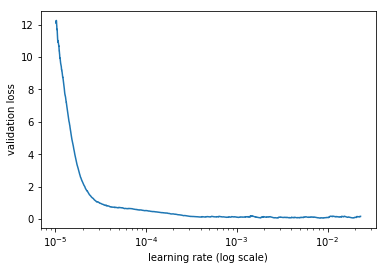

In [186]:
learner.sched.plot()

In [187]:
def exp_rmspe(y_pred, targ):
    """Kaggle defined metric"""
    targ = np.exp(targ)
    pct_var = (targ - np.exp(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [188]:
learning_rate = 1e-4

In [189]:
learner.fit(learning_rate, 3, metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.033375   0.038449   5.922323  
    1      0.022338   0.029939   5.753712                        
    2      0.017641   0.027816   5.933159                        


[array([0.02782]), 5.933158851551574]

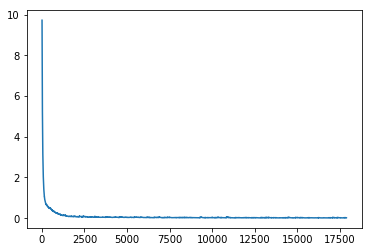

In [191]:
learner.sched.plot_loss()

In [ ]:
learner.fit(learning_rate, 3, metrics=[exp_rmspe], cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.013702   0.026844   5.821779  
    1      0.01398    0.027535   5.975091                        
    2      0.009758   0.025926   5.858351                         
    3      0.014003   0.026295   5.969393                         
    4      0.009488   0.02555    5.884871                         
Validation:  11%|█         | 111/994 [00:00<00:03, 268.72it/s]    